## Shifted calendars 
In s2s weather forecasting modelling we often use a calendar type that 'rolls' forward 
over time.

For example, we wish to forecast temperature for every week of June and July with a two 
week leadtime, keeping that leadtime constant. 

This imitates an Numerical Weather Prediction (NWP) model that is initiated every week.

Another example could be that we wish to investigate the influence of intraseasonal 
variability of one of our precursors over time.

With `s2spy.calendar_shifter`, the user can easily create calendars that suit these needs.
This notebook shows how to:
  * Shift a calendar n number of times and return a list of those calendars
  * Resample a dataset to those calendars resulting in an `xarray.Dataset`
    where the data is concatenated along a new dimension with default name 'step'

Note that the anchor year for every target period is kept the same relative to the first
calendar. Even if a target period is shifted to the next year, the anchor year of the 
target period stays the same.

In [22]:
import s2spy.time
import s2spy.calendar_shifter
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

Let's initiate a calendar with the following characteristics:
  * starting on July 1st
  * 1 target interval with 7 days length
  * 4 precursor intervals of 7 days length
  * 14 days leadtime between the target interval and first precusor interval

Setting relative_dates=True. To see absolute dates, first call calendar.map_years or calendar.map_data


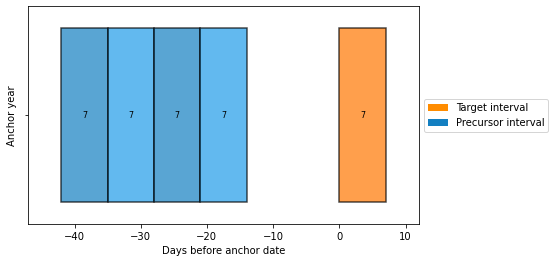

In [23]:
cal = s2spy.time.Calendar(anchor='07-01')
cal.add_intervals("target", "7d")
cal.add_intervals("precursor", "7d", gap="14d")
cal.add_intervals("precursor", "7d", n=3)
cal.visualize(show_length=True)

Then we build up a list of calendars. We shift (using `s2spy.calendar_shifter.staggered_calendar`) the initial calendar by 7 days three times such that we get four calendars:

(note that the anchor date does not change, only the gaps relative to the anchor date change)

In [24]:
cal_list =  s2spy.calendar_shifter.staggered_calendar(cal, shift='7d', n_shifts=3)

We map all the calendars to some year (2021) before visualizing:

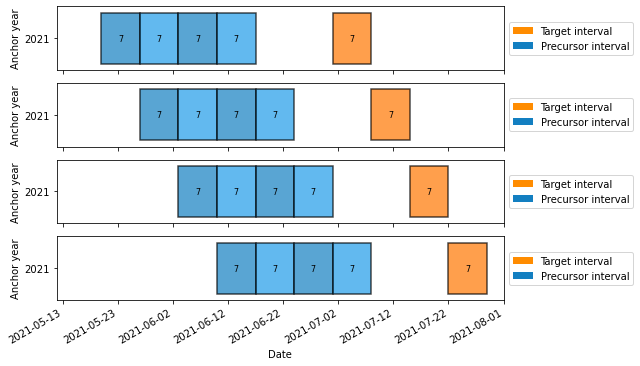

In [25]:
for cal in cal_list:
    cal.map_years(2021,2021)
    
fig, axes = plt.subplots(nrows=len(cal_list), sharex=True, figsize=(8,6))
for i, cal in enumerate(cal_list):
    cal.visualize(n_years=1, relative_dates=False, show_length=True, ax=axes[i])
axes[-1].set_xlim([np.datetime64("2021-05-12"), np.datetime64("2021-08-01")])
fig.autofmt_xdate()

Before resampling, we make a dummy dataset:

In [26]:
time_index = pd.date_range('20160101', '20211231', freq='1d')
ds = xr.Dataset(
    data_vars=dict(data=('time', np.random.random(len(time_index)))),
    coords=dict(time=time_index)
)
ds

<xarray.Dataset>
Dimensions:  (time: 2192)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2021-12-31
Data variables:
    data     (time) float64 0.7542 0.6469 0.9521 0.8415 ... 0.3956 0.8287 0.1396

Resample by using the `s2spy.calendar_shifter.calendar_list_resampler` function.

Before we resample, it is important to map our calendar to the desired years. Before, we mapped it to the year
it to 2021. Now, we can set it to other years using:

```py
for cal in cal_list:
    cal.map_years(2018,2021)
```

or we use the cal.map_to_data function to map our calendar to the dummy dataset:

```py
for cal in cal_list:
    cal.map_to_data(ds)
```

Map to data:

In [27]:
for cal in cal_list:
    cal.map_to_data(ds)

Now we we have to resample `ds` to all the calendars in `cal_list` using 
`s2spy.time.resample`.

We can do that with a simple list comprehension:

In [28]:
ds_r_list = [s2spy.time.resample(cal, ds) for cal in cal_list]

If you wish to also concatenate all resampled data to one `xr.Dataset`, we can use the 
built-in `s2spy.calendar_shifter.calendar_list_resampler` function which resamples the 
data to all the calendars in cal_list and concatenates these datasets along a new 
dimension (default name is 'step').

In [29]:
ds_r = s2spy.calendar_shifter.calendar_list_resampler(cal_list, ds)
ds_r

<xarray.Dataset>
Dimensions:      (anchor_year: 6, i_interval: 5, step: 4, bounds: 2)
Coordinates:
  * anchor_year  (anchor_year) int64 2021 2020 2019 2018 2017 2016
  * i_interval   (i_interval) int64 -4 -3 -2 -1 1
    interval     (step, anchor_year, i_interval, bounds) datetime64[ns] 2021-...
    target       (i_interval) bool False False False False True
  * step         (step) int64 0 1 2 3
Dimensions without coordinates: bounds
Data variables:
    data         (step, anchor_year, i_interval) float64 0.4237 ... 0.6039